<a href="https://colab.research.google.com/github/sanujsriv/_topic_models/blob/FoTo/FoTo_Keyw_EMB_Injection_ICDM_10Feb_WTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
# from google import colab # works only in colab (prevents from accidentally deleting files from NMSU server)
def clear_colab():
  home_dir = '/content/'
  os.chdir(home_dir)
  !rm -r *

In [ ]:
home_dir = os.getcwd()
min_df = 0
perc_vocab = 0.7
d_data='bbc'  # reuters, twentynews, webkb, wos, crowdgender,bbc,searchsnippet,yahooanswers,agnews120k
dtype = 'short'
all_vocab = True # False
injection = False
home_dir

'/content'

In [ ]:
!nvidia-smi

Mon Feb 14 17:40:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    28W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%cd /content/
if d_data == "twentynews":
  !wget -N -c https://www.dropbox.com/s/7yj1yvzpw589018/twentynews_4000.zip
  !unzip twentynews_4000.zip

/content


#⬅️ **0. Just Run these..**

In [ ]:
#@title Imports
# from sympy.stats import RaisedCosine, density
# from nltk.corpus import stopwords
import pandas as pd
import re
from time import time
import numpy as np
import collections
import gc
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
import shutil
from collections import Counter
# cos_sim = nn.CosineSimilarity(dim=-1,eps=1e-08)

### pickle
import pickle
!pip install pickle5
import pickle5
import bz2
import _pickle as cPickle


### plots
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sb
from matplotlib import pyplot as plt


#### torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Parameter
import subprocess


In [ ]:
#@title function : load / save pickle_obj

def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

def load_obj_pkl5(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle5.load(f)

def compressed_pickle(data,title):
  with bz2.BZ2File(title + '.pbz2', 'w') as f:
    cPickle.dump(data, f)

def decompress_pickle(file):
 data = bz2.BZ2File(file+'.pbz2', 'rb')
 data = cPickle.load(data)
 return data

## **Download Data (Short & Full Documents)**

In [ ]:
def short_text_datasets():
  if not os.path.exists("VLDB_WTM_Datasets.zip"):
    !wget -N -c https://www.dropbox.com/s/0vzwa9eagkmgi0q/VLDB_WTM_Datasets.zip
    !unzip -o VLDB_WTM_Datasets.zip
    if all_vocab == True:
      if d_data == "bbc":
        dir ='/content/content/data_'+d_data
        shutil.rmtree(dir)
        !wget -N -c https://www.dropbox.com/s/2ow6rn3xgtpg6uq/bbc_all_vocab_.zip
        !unzip bbc_all_vocab_.zip


In [ ]:
# def download_twenty_news():
#   !wget -N https://www.dropbox.com/s/09y9y1h0xk3cxaj/embeddings_twentynews.pkl
#   !wget -N https://www.dropbox.com/s/ewv3vcwgll0r8a7/data_twentynews_labels.pkl
#   !wget -N https://www.dropbox.com/s/chpjn9lzr7rmn2k/fixed_data_twentynews_preprocessed.pkl

In [ ]:
def download_reuters():
  !wget -N https://www.dropbox.com/s/8khmuj31il8zgkp/data_reuters_labels.pkl
  !wget -N https://www.dropbox.com/s/bgc1ht0jsyjed6s/embeddings_reuters.pkl
  !wget -N https://www.dropbox.com/s/9fk30bjzeefvhgl/data_reuters_preprocessed.pkl

In [ ]:
def download_webkb():
  !wget -N https://www.dropbox.com/s/wz88fk42r0viqvo/data_webkb_preprocessed.pkl
  !wget -N https://www.dropbox.com/s/8oi5qactwrar1ad/data_webkb_labels.pkl
  !wget -N https://www.dropbox.com/s/go7r4h39q6l01d5/embeddings_webkb.pkl

In [ ]:
def download_WoS():
  # !wget -N -c https://www.dropbox.com/s/3bse48k5kjpt5zd/wos_full_short_all_vocab.zip
  # !unzip -o wos_full_short_all_vocab.zip
  !wget -N -c https://www.dropbox.com/s/td8vf1lqmau41vn/wos_full_iter200_sent.zip
  !unzip -o wos_full_iter200_sent.zip

  # !wget -N https://www.dropbox.com/s/c6wlr148lhwsbaz/embeddings_wos.pkl
  # !wget -N https://www.dropbox.com/s/j96061ln6oeejkf/data_wos_preprocessed.pkl
  # !wget -N https://www.dropbox.com/s/kiffa4nidkjt7wi/data_wos_labels.pkl

In [ ]:
def download_unzip_crowdgender():
  !wget -N https://www.dropbox.com/s/trz5uph29b0t0eg/data_crowder.zip
  os.system('unzip data_crowder.zip')

In [ ]:
def download_data(data,dtype):
  data = data.lower()
  dtype = dtype.lower()
  if data == 'reuters':
    download_reuters()
  elif data == 'crowdgender':
   download_unzip_crowdgender()
  elif data == 'webkb':
    download_webkb()
  elif data == 'wos':
    download_WoS()
  # elif dtype == 'short':
  #   short_text_datasets()

  elif data == 'searchsnippet' and dtype =='short' and all_vocab:
    !wget -N -c https://www.dropbox.com/s/vu3ftyv72fodfiv/searchsnippet_all_vocab_.zip
    !unzip -o searchsnippet_all_vocab_.zip
  elif data == 'agnews120k' and dtype =='short' and all_vocab:
    !wget -N -c https://www.dropbox.com/s/wvx9ed1rop9vjkg/agnews120k_all_vocab_.zip
    !unzip -o agnews120k_all_vocab_.zip
  elif data=='bbc' and dtype =='short' and all_vocab:
    !wget -N -c https://www.dropbox.com/s/4mxikpqoj26rmsg/bbc_short_all_vocab_.zip
    !unzip -o bbc_short_all_vocab_.zip
  elif data=='bbc' and dtype =='full' and all_vocab:
    # dir ='/content/content/data_'+d_data
    # shutil.rmtree(dir)
    # !wget -N -c https://www.dropbox.com/s/e2ftkdd742chouz/bbc_full_short_all_vocab_.zip
    # !unzip -o bbc_full_short_all_vocab_.zip
    !wget -N -c https://www.dropbox.com/s/t217pxhn280njre/bbc_full_all_vocab_200iter_sent.zip
    !unzip -o bbc_full_all_vocab_200iter_sent.zip

##**Data Loading functions**

In [ ]:
def load_data(d_data,dtype,generated):
  dir= home_dir+'/content/data_'+d_data+'/'+dtype
  # dir ='/content/content/data_'+d_data+'/'+dtype
  os.chdir(dir)
  data_preprocessed=load_obj_pkl5("data_preprocessed_"+d_data+"_"+dtype)
  data_preprocessed_labels=load_obj_pkl5("data_preprocessed_labels_"+d_data+"_"+dtype)
  if generated == False:
    embeddings=load_obj_pkl5("embeddings_"+d_data+"_"+dtype)
  # generated_embeddings=load_obj_pkl5("generated_embeddings_"+d_data+"_"+dtype)
  elif generated==True:
    embeddings = load_obj_pkl5("generated_embeddings_"+d_data+"_"+dtype)
  os.chdir(home_dir)
  return data_preprocessed,data_preprocessed_labels,embeddings,load_data.__name__

def load_20News_sentences():
  embeddings = load_obj('embeddings_twentynews_sent')
  data_preprocessed = load_obj('data_twentynews_preprocessed_sent')
  data_preprocessed_labels = load_obj("data_twentynews_labels_sent")
  doc_sent_id = load_obj('doc_id_sent_twentynews')
  return data_preprocessed,data_preprocessed_labels,embeddings,doc_sent_id,load_20News_sentences.__name__

def load_20News_reuters():
  data_preprocessed = load_obj('data_reuters_preprocessed')
  data_preprocessed_labels = load_obj("data_reuters_labels")
  embeddings = load_obj('embeddings_reuters')
  data_preprocessed.extend(load_obj('data_20News_preprocessed'))
  data_preprocessed_labels.extend(load_obj("data_20news_preprocessed_labels"))
  embeddings.update(load_obj('embeddings_20news'))
  return data_preprocessed,data_preprocessed_labels,embeddings,load_20News_reuters.__name__

## get_keywords

In [ ]:
def get_keywords(data):
  keywords_arxiv = ['molecular ','stimulation','liquid','fluid']
  keywords_webkb = ['student','department','india']
  keywords_r52 = ['mutual','fund','market','money']

  keywords_WoS = ['pediatric','protein','clone']
  keywords_20News_Reuters = ['oil','price','opec','bpd','barrel','saudi','production','mln','crude']

  # keywords_reuters = ['company', 'analyst', 'offer', 'pct', 'takeover', 'merger', 'record', 'dividend', 'pay', 'stock']
  # keywords_reuters = ['stock', 'dividend', 'inc']
  keywords_reuters = ['oil','crude','ship']
  # keywords =['stock']
  # keywords_reuters = ['usa']

  keywords_crowdgender = ['housewife','girl','beautiful','blonde']

  keywords_20News = ['sport','game','baseball']
  # keywords_20News = ['looking' ,'add', 'voice' ,'input', 'capability', 'user', 'interface']

  # keywords_bbc=['fuel','reserve','oil']
  # keywords_bbc=['fuel','oil','game','win']
  # keywords_bbc=['fuel','oil','crude']
  # keywords_bbc=['fuel','usa'] #,'politics'
  # keywords_bbc = ['stock','apple','increase']
  keywords_bbc = ['microsoft','computer']
  # keywords_bbc = ['apple','microsoft', 'stock']
  # keywords_bbc = ['apple','stock']
  # keywords_bbc = ['fuel']
  # keywords_bbc = ['microsoft','fuel']
  # keywords_bbc = ['apple','microsoft','stock']

  # keywords_bbc = ['politics']#,'security','minister']
  # keywords_bbc = ['sport','league','rugby']

  ## all infreq
  # keywords_bbc = ['mcdonald', 'food','delivery']
  # keywords_bbc = ['business','entertainment','politics']
  # keywords_bbc = ['clumsy','food']
  keywords_bbc = ['star','singer']

  # keywords_searchsnippet = ['politics','drama','minister']
  keywords_searchsnippet = ['korean','drama']
  keywords_yahooanswers = ['anger','hate','crime']
  # keywords_agnews = ['computer','apple','microsoft']
  keywords_agnews = ['auto','gasoline']

  data = data.lower()
  if data=='reuters': keywords = keywords_reuters
  elif data=='twentynews':keywords = keywords_20News
  elif data=='crowdgender':keywords = keywords_crowdgender
  elif data=='webkb':keywords = keywords_webkb
  elif data=='bbc': keywords = keywords_bbc
  elif data=='searchsnippet': keywords = keywords_searchsnippet
  elif data=='yahooanswers': keywords = keywords_yahooanswers
  elif data=='agnews120k': keywords = keywords_agnews
  elif data=='wos': keywords = keywords_WoS
  else:
    print('keyword list not found!!!')
  return keywords

##DESM Score Function

In [ ]:
def cosine_similarity_desm_docs(query_list, train_vec, vocab, embeddings):
  num_docs = train_vec.shape[0]
  num_voc = len(vocab)
  sim_list = torch.zeros(num_docs)
  index = 0
  id_vocab = dict(map(reversed, vocab.items()))
  for d in range(num_docs):
    if(d%5000==0): print(d)
    doc_bar = torch.zeros(300)
    doc_length = 0
    for v in range(num_voc):
      if(train_vec[d][v] > 0):
        doc_bar.add_(train_vec[d][v] * torch.from_numpy(embeddings[id_vocab[v]])/torch.norm(torch.from_numpy(embeddings[id_vocab[v]])))
        doc_length = doc_length + train_vec[d][v]
    doc_bar = doc_bar / doc_length
    sum = 0

    for q in query_list:
      sum += torch.dot(torch.from_numpy(embeddings[q]) , doc_bar)/(torch.norm(torch.from_numpy(embeddings[q]))*torch.norm(doc_bar))
    sum = sum/len(query_list)
    sim_list[index]=sum
    index = index + 1

  return sim_list

In [ ]:
def cosine_similarity_desm_docs_forlarge(query_list, train_vec, vocab, embeddings):
  num_docs = train_vec.shape[0]
  num_voc = len(vocab)
  sim_list = torch.zeros(num_docs)
  index = 0
  id_vocab = dict(map(reversed, vocab.items()))
  for d in range(num_docs):
    if(d%5000==0): print(d)
    doc_bar = torch.zeros(300)
    doc_length = 0
    for v in range(num_voc):
      train_vec_val = train_vec[d].toarray()[0][v]
      if(train_vec_val > 0):
        doc_bar.add_(train_vec_val * torch.from_numpy(embeddings[id_vocab[v]])/torch.norm(torch.from_numpy(embeddings[id_vocab[v]])))
        doc_length = doc_length + train_vec_val
    doc_bar = doc_bar / doc_length
    sum = 0

    for q in query_list:
      sum += torch.dot(torch.from_numpy(embeddings[q]) , doc_bar)/(torch.norm(torch.from_numpy(embeddings[q]))*torch.norm(doc_bar))
    sum = sum/len(query_list)
    sim_list[index]=sum
    index = index + 1

  return sim_list


## functions (Plot_loss, get_topwords, get_Z, get_Contour, print_Topics)

In [ ]:
import plotly.graph_objects as go
def plot_relative_diff(x,y,y2,name2,title,yaxis_title,xaxis_title):
  fig = go.Figure()
  fig.add_trace(go.Scatter(x=x, y=y,
                      mode='lines+markers',
                      name="FoTo"))
  fig.add_trace(go.Scatter(x=x, y=y2,
                      mode='lines+markers',
                      name=name2))

  fig.update_layout(title=title,
                    yaxis_title=yaxis_title,
                    xaxis_title=xaxis_title)

  fig.show(renderer='colab')

In [ ]:
def getall_tensor_size():
  for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
            print(type(obj), obj.size(),get_mem_size(obj))
    except:
        pass

def list_of_tensors_to_tensor(loT):
  stacked_tensor = torch.stack(loT)
  return stacked_tensor

def get_labels_dict(unique_labels):
  labels_dict = {}
  for l in unique_labels:
    labels_dict[l] = 'C'+str(unique_labels.index(l))
  return labels_dict

def get_topwords(beta, id_vocab,topwords):
    topic_indx = 0
    topwords_topic = []
    topic_topwords = topwords
    for i in range(len(beta)):
        topwords_topic.append( str(topic_indx)+": "+ " ".join([id_vocab[j] for j in beta[i].argsort()[:-topic_topwords - 1:-1]]))
        topic_indx+=1
    return topwords_topic

def print_Topics(topwords):
  print("---"*10)
  topword_topics = get_topwords(beta, id_vocab,topwords)
  topword_topics_list=[]
  for topwords in topword_topics:
      topword_topics_list.append(topwords.split())
      print(topwords)
  print("---"*10)

In [ ]:
def plot_loss(y,name):
  figure = go.Figure()
  figure.add_trace(go.Scatter(x=[i for i in range(1,epochs+1)], y=y,mode='lines',name=name))
  figure.show(renderer='colab')

def plot_fig(zx, labels_list, zphi, query_center,query_words,keywords,lim,contour='No'):

    fig, ax = plt.subplots( figsize=(20, 20))
    if contour=='yes':
       get_Contour(ax,zx,lim)

    label_colors_dict = get_labels_dict(sorted_unique_labels)
    # sb.scatterplot(ax=ax,x=zx[:,0],y=zx[:,1],hue=labels_list,alpha=0.8,palette='deep')
    sb.scatterplot(ax=ax,x=zx[:,0],y=zx[:,1],hue=labels_list,alpha=0.8,palette=label_colors_dict)

    ax.set(ylim=(-lim,lim))
    ax.set(xlim=(-lim,lim))

    # ax.text(query_center[0],query_center[1], 'X' ,c='red')
    # ax.text(0,0, 'X' ,c='black')
    for i in range(len(query_words)):
      if (i==len(query_words)-1):
        ax.text(query_words[i][0],query_words[i][1], 'X'+keywords[i] ,c='black',weight='bold')
      else:
        ax.text(query_words[i][0],query_words[i][1], 'X'+keywords[i] ,c='black',weight='bold')

    ax.scatter(zphi[:, 0], zphi[:, 1], alpha=1.0,  edgecolors='black', facecolors='none', s=30)

    for indx, topic in enumerate(zphi):
        ax.text(zphi[indx, 0], zphi[indx, 1], 'topic'+str(indx))



def get_Z(X,Y):
  norms = torch.zeros(X.shape)
  Z = torch.zeros(X.shape)

  for i in range(X.shape[0]):
    for j in range(X.shape[0]):
      v = torch.tensor([X[i][j],Y[i][j]])

      norms[i][j] = torch.norm(v)
      Z[i][j]=torch.exp(-0.5 * (torch.pow(norms[i][j],2))/mu_div)

      # norms[i][j] = (v-query_center.T).pow(2).sum(-1)
      # Z[i][j]=torch.exp(-0.5 * norms[i][j]/mu_div)
  return Z

def get_Contour(ax,x_list,lim):
  xlist = np.linspace(-lim, lim, 200)
  ylist = np.linspace(-lim, lim, 200)
  X, Y = np.meshgrid(xlist, ylist)
  Z = get_Z(X,Y)
  levels = np.arange(0,1,0.1)
  cp = ax.contour(X, Y, Z, levels=levels)
  ax.clabel(cp, inline=1, fontsize=10)


def get_gpu_memory_map():
    """Get the current gpu usage.
    Returns
    -------
    usage: dict
        Keys are device ids as integers.
        Values are memory usage as integers in MB.
    """
    result = subprocess.check_output(
        [
            'nvidia-smi', '--query-gpu=memory.used',
            '--format=csv,nounits,noheader'
        ], encoding='utf-8')
    # Convert lines into a dictionary
    gpu_memory = np.array([int(x) for x in result.strip().split('\n')])
    # gpu_memory_map = dict(zip(range(len(gpu_memory)), gpu_memory))
    return gpu_memory

def auto_select_gpu(memory_threshold = 7000, smooth_ratio=200, strategy='greedy'):
    gpu_memory_raw = get_gpu_memory_map() + 10
    if strategy=='random':
        gpu_memory = gpu_memory_raw/smooth_ratio
        gpu_memory = gpu_memory.sum() / (gpu_memory+10)
        gpu_memory[gpu_memory_raw>memory_threshold] = 0
        gpu_prob = gpu_memory / gpu_memory.sum()
        cuda = str(np.random.choice(len(gpu_prob), p=gpu_prob))
        print('GPU select prob: {}, Select GPU {}'.format(gpu_prob, cuda))
    elif strategy == 'greedy':
        cuda = np.argmin(gpu_memory_raw)
        print('GPU mem: {}, Select GPU {}'.format(gpu_memory_raw[cuda], cuda))
    return cuda

## Just Run (pytorch)

In [ ]:
#@title Weight Drop
def _weight_drop(module, weights, dropout):
    """
    Helper for `WeightDrop`.
    """
    for name_w in weights:
        w = getattr(module, name_w)
        del module._parameters[name_w]
        module.register_parameter(name_w + '_raw', Parameter(w))

    original_module_forward = module.forward

    def forward(*args, **kwargs):
        for name_w in weights:
            raw_w = getattr(module, name_w + '_raw')
            w = torch.nn.functional.dropout(raw_w, p=dropout, training=module.training)

            setattr(module, name_w, w)

        # return original_module_forward(*args, **kwargs)

    setattr(module, 'forward', forward)


class WeightDrop(torch.nn.Module):
    """
    The weight-dropped module applies recurrent regularization through a DropConnect mask on the
    hidden-to-hidden recurrent weights.

    **Thank you** to Sales Force for their initial implementation of :class:`WeightDrop`. Here is
    their `License
    <https://github.com/salesforce/awd-lstm-lm/blob/master/LICENSE>`__.

    Args:
        module (:class:`torch.nn.Module`): Containing module.
        weights (:class:`list` of :class:`str`): Names of the module weight parameters to apply a
          dropout too.
        dropout (float): The probability a weight will be dropped.

    Example:

        >>> from torchnlp.nn import WeightDrop
        >>> import torch
        >>>
        >>> torch.manual_seed(123)
        <torch._C.Generator object ...
        >>>
        >>> gru = torch.nn.GRUCell(2, 2)
        >>> weights = ['weight_hh']
        >>> weight_drop_gru = WeightDrop(gru, weights, dropout=0.9)
        >>>
        >>> input_ = torch.randn(3, 2)
        >>> hidden_state = torch.randn(3, 2)
        >>> weight_drop_gru(input_, hidden_state)
        tensor(... grad_fn=<AddBackward0>)
    """

    def __init__(self, module, weights, dropout=0.0):
        super(WeightDrop, self).__init__()
        _weight_drop(module, weights, dropout)
        self.forward = module.forward

class WeightDropLinear(torch.nn.Linear):
    """
    Wrapper around :class:`torch.nn.Linear` that adds ``weight_dropout`` named argument.

    Args:
        weight_dropout (float): The probability a weight will be dropped.
    """

    def __init__(self, *args, weight_dropout=0.0, **kwargs):
        super().__init__(*args, **kwargs)

        weights = ['weight']
        # print('name_w in _weight_drop: ', name_w)
        _weight_drop(self, weights, weight_dropout)

In [ ]:
# @title Targeted Dropout Class
import torch
import torch.nn as nn


class TargetedDropout(nn.Module):
    """
    Learning Sparse Networks Using Targeted Dropout
    https://arxiv.org/abs/1905.13678
    """

    def __init__(self,targeted="weight",target_layer=None,
                 dropout_rate=0.5,targeted_portion=0.5):
        super(TargetedDropout, self).__init__()
        self.targeted = targeted
        self.target_layer = target_layer
        self.dropout_rate = dropout_rate
        self.targeted_portion = targeted_portion
        self.weight = target_layer.weight

        if self.targeted == "weight":
            self.targeted_dropout = targeted_weight_dropout
        elif self.targeted == "unit":
            self.targeted_dropout = targeted_unit_dropout

    def forward(self):
        self.weight = self.targeted_dropout(
            weight=self.target_layer.weight,
            dropout_rate=self.dropout_rate,
            targeted_portion=self.targeted_portion,
            is_training=self.training,
        )

        self.target_layer.weight = self.weight
        # output = self.target_layer(x)
        return self.weight

    def extra_repr(self):
        return f"targeted={self.targeted}, dropout_rate={self.dropout_rate}, targeted_portion={self.targeted_portion}"


def targeted_weight_dropout(weight, dropout_rate, targeted_portion, is_training):
    weight_shape = weight.shape
    weight = torch.reshape(weight, [-1, weight_shape[-1]]).float()

    norm = torch.abs(weight)
    idx = int(targeted_portion * torch.tensor(weight.shape[0]).float())
    threshold = torch.sort(norm, dim=0)[0][idx]
    mask = norm < threshold[None, :]

    if not is_training:
        mask = (torch.rand_like(weight) < dropout_rate).to(mask.device.type) & mask

    weight = (1.0 - mask.float()) * weight
    weight = torch.reshape(weight, weight_shape)
    weight = torch.nn.Parameter(weight)

    return weight

def targeted_unit_dropout(weight, dropout_rate, targeted_portion, is_training):
    weight_shape = weight.shape
    weight = torch.reshape(weight, [-1, weight_shape[-1]]).float()

    norm = torch.norm(weight, dim=0)
    idx = int(targeted_portion * int(weight.shape[1]))
    sorted_norms = torch.sort(norm)[0]
    threshold = sorted_norms[idx]
    mask = (norm < threshold)[None, :]
    mask = mask.repeat(weight.shape[0], 1)

    if not is_training:
        mask = torch.where(
            ((1.0 - dropout_rate) < torch.rand_like(weight)).to(mask.device.type)
            & mask,
            torch.ones_like(weight, dtype=torch.float32),
            torch.zeros_like(weight, dtype=torch.float32),
        )

    weight = (1.0 - mask.float()) * weight
    weight = torch.reshape(weight, weight_shape)
    weight = torch.nn.Parameter(weight)

    return weight

# **1. Prepare Data**

In [ ]:
#### Data Downloading ####
download_data(d_data,dtype) ### Run Once

--2022-02-14 17:40:10--  https://www.dropbox.com/s/4mxikpqoj26rmsg/bbc_short_all_vocab_.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6030:18::a27d:5012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/4mxikpqoj26rmsg/bbc_short_all_vocab_.zip [following]
--2022-02-14 17:40:10--  https://www.dropbox.com/s/raw/4mxikpqoj26rmsg/bbc_short_all_vocab_.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucec9e312f7122c499afe8fc8841.dl.dropboxusercontent.com/cd/0/inline/BftlUv5vo1bLbrXXxjXlFb_XjwsjaBca7Mu0k0KXU5Dba1PeVeWiO2gegJ-UdlMUYtwlBY85yFYIuO0bHcxdvoT7Aox_jV1dfL9EcOJCmZoX7P2Q1iKD3SbsR824m4KR1UiK-VjmaRn0sFZeXHY03iQP/file# [following]
--2022-02-14 17:40:10--  https://ucec9e312f7122c499afe8fc8841.dl.dropboxusercontent.com/cd/0/inline/BftlUv5vo1bLbrXXxjXlFb_XjwsjaBca7Mu0k0KXU5Dba1PeVeW

In [ ]:
# ##### Data loading #####
# dtype='short'
loaded_data = load_data(d_data,dtype,generated=False)
##########################

data_preprocessed , data_preprocessed_labels , embeddings, name = loaded_data
max_features=int(len(embeddings)*perc_vocab)

# if len(embeddings)>10000:
#   max_features = 10000
sorted_unique_labels = sorted(set(data_preprocessed_labels))

# for d in range(len(data_preprocessed)):
#   data_preprocessed[d] = doc_remove_extra_stopwords(data_preprocessed[d])
print(name,d_data,len(data_preprocessed_labels),len(data_preprocessed),len(embeddings),max_features)

load_data bbc 2224 2224 5733 4013


### injection

In [ ]:
if injection:
  d = Counter(data_preprocessed_labels)
  rare_class = min(d, key=d.get)
  rare_class_nlabels = d[rare_class]

  np.random.seed(seed=len(data_preprocessed_labels))
  np_data = np.asarray(data_preprocessed)
  np_labels = np.asarray(data_preprocessed_labels)

  to_change = np.where(np_labels != rare_class)[0]
  to_change_with  =  np.where(np_labels == rare_class)[0]
  rand_perm_k_to_change_with = np.random.permutation(to_change_with)
  rand_perm_k_to_change = np.random.permutation(to_change)

  to_change_with_docs = np_data[rand_perm_k_to_change_with]
  to_change_docs =  np_data[rand_perm_k_to_change]
  print('Before Injection - \n',data_preprocessed[rand_perm_k_to_change[0]])
  # dict_docs[to_change_label] = to_change_docs
  p=0.35
  n_docs_changed = 0
  changed_docs = []
  for i in range(rare_class_nlabels):
    words = to_change_with_docs[i].split()
    words_to_change = to_change_docs[i].split()
    perc = int(len(words_to_change)*p)
    if perc == 0:
      continue
    # perc_to_change = min(perc1,perc2)
    # random.shuffle(words)
    # random.shuffle(words_to_change)
    n_docs_changed = n_docs_changed+1
    to_change_docs[i] = " ".join(words[:perc] + words_to_change)
    changed_docs.append(to_change_docs[i])
    data_preprocessed[rand_perm_k_to_change[i]] = to_change_docs[i]
  print('After Injection - \n',data_preprocessed[rand_perm_k_to_change[0]])

  np_data_new = np.asarray(data_preprocessed)
  np_data_new[to_change_with] = ''
  new_data = []
  new_labels = []
  for d in range(len(np_data_new)):
    if len(np_data_new[d])!=0:
      new_data.append(data_preprocessed[d])
      new_labels.append(data_preprocessed_labels[d])

In [ ]:
#@title to inject individually
# if injection:
# # from random import shuffle
# # import random

# to_change_labels = ['politics','sport']
# for to_change_label in to_change_labels:
#   np.random.seed(seed=len(data_preprocessed_labels))
#   np_labels = np.asarray(data_preprocessed_labels)
#   # to_change = np.where(np_labels == 'sport')[0]
#   to_change = np.where(np_labels == to_change_label)[0]
#   to_change_with  =  np.where(np_labels == 'tech')[0]
#   rand_perm_k_to_change_with = np.random.permutation(to_change_with) # int(len(to_change_with)*k/100)
#   rand_perm_k_to_change = np.random.permutation(to_change) # int(len(to_change)*k/100)

#   k = min(len(rand_perm_k_to_change_with),len(rand_perm_k_to_change))
#   # k = int(k*0.35)

#   rand_perm_k_to_change_with = rand_perm_k_to_change_with[:k]
#   rand_perm_k_to_change = rand_perm_k_to_change[:k]

#   np_data = np.asarray(data_preprocessed)
#   to_change_with_docs = np_data[rand_perm_k_to_change_with]
#   to_change_docs =  np_data[rand_perm_k_to_change]
#   dict_docs[to_change_label] = to_change_docs
#   p=0.35
#   for i in range(k):
#     words = to_change_with_docs[i].split()
#     words_to_change = to_change_docs[i].split()

#     original_words = words.copy()
#     original_words_to_change = words_to_change.copy()

#     # perc1 = int(len(words)*p)
#     perc2 = int(len(words_to_change)*p)

#     # perc_to_change = min(perc1,perc2)
#     # random.shuffle(words)
#     # random.shuffle(words_to_change)

#     to_change_docs[i] = " ".join(words[:perc2] + original_words_to_change[perc2:])

#     data_preprocessed[rand_perm_k_to_change[i]] = to_change_docs[i]

### prepare data for model

In [ ]:
data_islarge = False
if injection:
  preprossed_data = new_data
  train_label = new_labels
else:
  preprossed_data = data_preprocessed
  train_label = data_preprocessed_labels
vectorizer = CountVectorizer(min_df=min_df,max_features=max_features)
if len(preprossed_data) > 45000:
  data_islarge= True
  train_vec = vectorizer.fit_transform(preprossed_data)
  vocab = vectorizer.vocabulary_
  id_vocab = dict(map(reversed, vocab.items()))
  train_label = np.asarray(train_label)
else:
  train_vec = vectorizer.fit_transform(preprossed_data).toarray()
  vocab = vectorizer.vocabulary_
  id_vocab = dict(map(reversed, vocab.items()))
  nonzeros_indexes = np.where(train_vec.any(1))[0]
  train_vec_non_zeros = [train_vec[i] for i in nonzeros_indexes]
  preprossed_data_non_zeros = [preprossed_data[i] for i in nonzeros_indexes]
  train_label = [train_label[i] for i in nonzeros_indexes]

# train_vec = np.asanyarray(train_vec_non_zeros)
num_input = train_vec.shape[1]

print(train_vec.shape)
print(train_label)
print(vocab)

(2224, 4013)
['business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'b

In [ ]:
np.where(train_vec.sum(0) ==0)

(array([], dtype=int64),)

In [ ]:
# tfidfvectorizer = TfidfVectorizer(min_df=min_df,max_features=max_features)
# tfidf_vec = tfidfvectorizer.fit_transform(data_preprocessed).toarray()

In [ ]:
keywords = get_keywords(d_data)

# commented for WoS
if data_islarge == True:# pass
  all_rscores = cosine_similarity_desm_docs_forlarge(keywords,train_vec,vocab,embeddings)
else:
  all_rscores = cosine_similarity_desm_docs(keywords,train_vec,vocab,embeddings)

0


In [ ]:
device = torch.device("cuda:"+str(auto_select_gpu()) if torch.cuda.is_available() else "cpu")
if data_islarge: pass
else: tensor_train_w = torch.from_numpy(train_vec).float()
train_label = np.asarray(train_label)

GPU mem: 12, Select GPU 0


In [ ]:
# @title for individual injection
# if injection:
  # changed_docs_categories = ['politics','sport']
  # docs_idx_dict = {}
  # for c in changed_docs_categories:
  #   docs_idx = []
  #   all_docs = dict_docs[c]
  #   for a in all_docs:
  #     docs_idx.append(preprossed_data_non_zeros.index(a))
  #   docs_idx_dict[c] = docs_idx

In [ ]:
if injection:
  changed_docs_idx = [preprossed_data_non_zeros.index(a) for a in changed_docs]

# **2. Scores**

## DESM Score

In [ ]:
top_10_docs=[]
sort,indices = torch.sort(all_rscores,descending=True)
print('Keywords',keywords)
print('Descending :',sort,'\n','indices:',indices)
print('\n\n Top 10 Relevant Documents (DESM):\n\n',"---"*40)

for k in range(10):
   print(k+1,') ',preprossed_data_non_zeros[indices[k].item()])
   print(k+1,')',train_label[indices[k].item()])

with open("1000.txt", "w") as output:
  for k in range(0,1000):
    output.write(str(k+1)+') '+str(preprossed_data_non_zeros[indices[k].item()])+'\n')
    output.write(str(k+1)+') '+str(sort[k].item())+'\n')
    output.write(str(k+1)+') '+str(train_label[indices[k].item()])+'\n')
output.close()

scaler = MinMaxScaler(feature_range=(0+1e-10, 0.99))
normalized_all_rscores = scaler.fit_transform(all_rscores.data.reshape(-1,1))
normalized_all_rscores=torch.tensor(normalized_all_rscores.flatten())

sorted_docs, sorted_idxs = torch.sort(normalized_all_rscores,descending=True)
rounded_normalized_all_rscores = torch.round(normalized_all_rscores*10)/10.0

Keywords ['star', 'singer']
Descending : tensor([ 0.6747,  0.5770,  0.5644,  ..., -0.0032, -0.0058, -0.0090]) 
 indices: tensor([ 769,  685,  741,  ...,  319, 1959,  135])


 Top 10 Relevant Documents (DESM):

 ------------------------------------------------------------------------------------------------------------------------
1 )  singer christina pop star christina marry music executive jordan singer agent confirmed
1 ) entertainment
2 )  comeback friend star friend actress lisa play lead role series time sitcom star hollywood reporter
2 ) entertainment
3 )  lead broadway singer actor harry star broadway revival hit musical pajama game
3 ) entertainment
4 )  husband plan debut duet singer jennifer lopez husband marc anthony latin pop star perform duet month grammy award los angeles
4 ) entertainment
5 )  star enter rock hall fame singer bruce inducted irish rock band rock roll hall fame york
5 ) entertainment
6 )  reef hollywood star actor reef best role matrix movie awarded star 

In [ ]:
# plt.hist(normalized_all_rscores)

In [ ]:
# plt.hist(rounded_normalized_all_rscores)

In [ ]:
from collections import defaultdict

contains_key = 0
doc_contains__anykey_idx = []
for doc in preprossed_data_non_zeros:
  for k in keywords:
    if k in doc:
      contains_key += 1
      doc_contains__anykey_idx = np.append(doc_contains__anykey_idx,preprossed_data_non_zeros.index(doc)).astype(int)
      break

doc_contains_anykey = torch.zeros(train_vec.shape[0])
doc_contains_anykey[doc_contains__anykey_idx] = 1.0
# doc_contains_anykey = torch.zeros(tensor_train_w.size())
# for idx in doc_contains__anykey_idx:
#     doc_contains_anykey[idx][torch.where(tensor_train_w[idx]>0)[0]] = 1.0

def get_relv_words(docs_keys_idx,preprossed_data_non_zeros,vocab):
  relv_words  = []
  for d in docs_keys_idx:
    relv_words.extend(preprossed_data_non_zeros[d].split(' '))
  idx_relv_words = np.asarray(list(set([vocab[r] for r in relv_words])))
  return idx_relv_words

## Approach 1 - All words only in the docs containing the keyword are relevant  (.)

## Approach 2 - All words in the docs containing the keyword are relevant i.e. the same words if appear in other docs are relevant  (X)
N_V_relv_doc_cOnkey = torch.zeros(tensor_train_w.size())

doc_contains_keyidx = defaultdict(list)
for k in keywords:
  for doc in preprossed_data_non_zeros:
    if k in doc:
      dk_idx = preprossed_data_non_zeros.index(doc)
      doc_contains_keyidx[k].append(dk_idx)
      N_V_relv_doc_cOnkey[dk_idx][torch.where(tensor_train_w[dk_idx]>0)[0]] = 1.0 #  All words only in the docs containing the keyword are relevant


# idx_allkeys_relvWord = get_relv_words(doc_contains__anykey_idx,preprossed_data_non_zeros,vocab)
# idx_keys_relvWord = {}
# for k in keywords:
#   idx_keys_relvWord[k] =  get_relv_words(doc_contains_keyidx[k],preprossed_data_non_zeros,vocab)  # docs containing the keyword are relevant i.e. the same words if appear in other docs are relevant

In [ ]:
gc.collect()

320

In [ ]:
# import torch

# def log_bmm(a,b):
#     """Performs a batch matrix-matrix product of matrices in log-space.
#     Args:
#         a: tensor with shape (b, n, m)
#         b: tensor with shape (b, m, p)
#     Returns:
#         tensor with shape (b, n, p)
#     """
#     assert a.ndim == b.ndim == 3
#     assert a.size(0) == b.size(0)
#     assert a.size(2) == b.size(1)

#     bsz, p, m = a.size()
#     _, _, n = b.size()
#     a1 = a.unsqueeze(2).expand(bsz, p, n, m)
#     b1 = b.unsqueeze(1).transpose(2, 3).expand(bsz, p, n, m)
#     return torch.logsumexp(a1 + b1, dim=-1)

# a = torch.ones(10,5,20) * 5
# b = torch.ones(10,7,5) * 3

# log_bmm(a,b)

## Cosine Score

In [ ]:
cos_sim = nn.CosineSimilarity(dim=-1, eps=1e-8)
torch.pi = torch.acos(torch.zeros(1)).item() * 2
# model 5.3
sig_exp_dist = 50.0


def flatten_list(user_list): return [item for sublist in user_list for item in sublist]
def get_embedding_tensor(word_list,embeddings): return torch.tensor([embeddings[w] for w in word_list])


def cosine_angular_sim(keyword_torch,words_tensor): return 1 - (torch.acos(cos_sim(keyword_torch,words_tensor))) / torch.pi
def cosine_norm_01(keyword_torch,words_tensor): return (cos_sim(keyword_torch,words_tensor) + 1.0)/2.0
def cosine_sqrt(keyword_torch,words_tensor): return 1 - ((1 - cos_sim(keyword_torch,words_tensor) )/2)**0.5
def euclidean_dist(keyword_torch,words_tensor) : return ((words_tensor-keyword_torch).pow(2).sum(-1))**0.5

def edist(x,x1):
  dist = torch.pow((x-x1),2).sum(-1)
  dist_sim = torch.exp(-dist/0.1)
  return dist_sim


def inv_new_fn(x,x1):
  beta = 3
  dist = torch.pow((x-x1),2).sum(-1)
  dist_sim = 1.0 / (1.0 + (dist/(1-dist))**(-beta))
  return dist_sim

def exp_dist_sim_x_x1(x,x1,sig=sig_exp_dist):
  # sig = 0.1
  dist = torch.pow((x-x1),2).sum(-1)
  # dist2 = torch.norm((x-x1),dim=-1)**2
  exp_dist_sim = torch.exp(- dist / sig)
  return exp_dist_sim

def get_dist_val_score(f,keyword_torch,words_tensor):
  score = f(keyword_torch,words_tensor)
  return score

def cosine_keywords(keywords,words_tensor,word_list,similarity_function):
  all_keywords_score = []
  all_cosine_sim = []
  all_dist = []
  cosine_score_vocab = {}
  keyword_total_score = torch.zeros(words_tensor.shape[0])
  for k in keywords:
    keyword_torch = torch.from_numpy(embeddings[k])
    keyword_torch = keyword_torch.unsqueeze(0).expand(words_tensor.shape[0],words_tensor.shape[1])

    cosine_sim_score = cos_sim(keyword_torch,words_tensor)
    score = get_dist_val_score(similarity_function,keyword_torch,words_tensor)
    # cosine_score = cosine_sqrt(keyword_torch,words_tensor)
    # cosine_score = cosine_angular_sim(keyword_torch,words_tensor)
    # cosine_score = cosine_norm_01(keyword_torch,words_tensor)

    # cosine_score[idx_keys_relvWord[k]] = 1.0
    all_keywords_score.append(score)
    all_cosine_sim.append(cosine_sim_score)

    # dist_sim_val,dist_val = exp_dist_sim_x_x1(words_tensor,keyword_torch,sig_exp_dist)
    # dist_sim_val,dist_val = edist(keyword_torch,words_tensor,sig_exp_dist)

    # dist_sim_val[idx_keys_relvWord[k]] = 1.0
    # all_keywords_score.append(dist_sim_val)
    # all_dist.append(dist_val)

    keyword_total_score += cosine_sim_score
  keywords_max_score,keyword_max_score_idx = torch.max(torch.stack(all_keywords_score),dim=0)
  cosine_score_vocab = dict(zip(word_list,keywords_max_score.numpy()))

  return all_keywords_score,keyword_total_score/len(keywords),keywords_max_score,cosine_score_vocab,all_cosine_sim

In [ ]:
sorted_id_word_vocab = sorted(id_vocab.items(), key=lambda x: x[1]) ### alphabetically sorted
word_list = [s[1] for s in sorted_id_word_vocab]
words_tensor = get_embedding_tensor(word_list,embeddings)

# sorted_cosine_words_vocab = sorted(cosine_score_vocab.items(), key=lambda x: x[1]) ### cosine sim score sorted
# sorted_cosine_vocab = [s[0] for s in sorted_cosine_words_vocab]

embedding_tensor_sorted_alp = get_embedding_tensor(word_list,embeddings)
embedding_tensor_keywords = get_embedding_tensor(keywords,embeddings)
similarity_function = cosine_sqrt # exp_dist_sim_x_x1 # << your similarity function here
all_keywords_score,keywords_mean_score,keywords_max_score,cosine_score_vocab,all_cosine_sim = cosine_keywords(keywords,words_tensor,word_list,similarity_function)


idx_where_0 = torch.where(keywords_max_score <= 0.45)[0]
cosine_flag_testing = keywords_max_score.clone()
cosine_flag_testing[idx_where_0] = 0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  


In [ ]:
# key_idx = np.array([vocab[k] for k in keywords])

def min_max_norm_1(cosine_val):
  min_v = torch.min(cosine_val)
  # max_v = torch.topk(cosine_val,k=len(keywords)+1).values[-1]
  max_v = torch.max(cosine_val)
  # max_v=torch.max(cosine_val)
  val = (cosine_val - min_v) / ( (max_v - min_v) )
  # for i in range(len(key_idx)):
  #   val[key_idx[i]] = 1.0
  return val

In [ ]:
# val = min_max_norm_1(list_of_tensors_to_tensor(all_cosine_sim),key_idx)
# threshold_focus = 0.0

# most_sim_key_V_K1 = torch.zeros(num_input,len(keywords))
# filter = torch.zeros(num_input)

# for i in range(num_input):
#   maximum,index = torch.max(val[:,i],-1)
#   if(maximum>threshold_focus):
#     most_sim_key_V_K1[i][int(index)] = 1.0
#     filter[i] = 1

In [ ]:
####@title Threshold focus (quantile)
threshold_focus_quantile = 0.5 #@param {type:"slider", min:0.1, max:1.0, step:0.05}

val = min_max_norm_1(list_of_tensors_to_tensor(all_cosine_sim))
# val = (list_of_tensors_to_tensor(all_cosine_sim))
# val = (list_of_tensors_to_tensor(all_keywords_score))
a = val
q = torch.tensor([threshold_focus_quantile])#0.25, 0.5, 0.75])
q_v = torch.quantile(a, q, dim=1, keepdim=True)[0]

most_sim_key_V_K1 = torch.zeros(num_input,len(keywords))
# most_sim_key_V_K1 = torch.zeros(num_input,len(keywords))
filter = torch.zeros(num_input)

for i in range(num_input):
  maximum,index = torch.max(val[:,i],-1)
  # minimum,index = torch.min(val[:,i],-1)
  #q_v[index][0] = 0.1
  if(maximum>q_v[index][0]):
  # if(minimum<q_v[index][0]):

    most_sim_key_V_K1[i][int(index)] = 1.0
    filter[i] = 1
  # else:
  #   # most_sim_key_V_K1[i][len(keywords)] = 1.0
  #   most_sim_key_V_K1[i] = torch.ones(len(keywords))
  #   filter[i] = 1

In [ ]:
most_sim_key_V_K1.sum()

tensor(2721.)

In [ ]:
# word_list[vocab['apple']]

In [ ]:
# k=232
# keywords_and_dummy = keywords#+['dummy']
# idx_list = []
# all_w= []
# doc_words = data_preprocessed[k].split(' ')
# for d in doc_words:
#   if d in word_list:
#     all_w.append(d)
#     idx_list.append(torch.where(most_sim_key_V_K1[vocab[d]]==1)[0].item())
#   else: pass
# idx_list
# #   if d in word_list:
# #     idx_list.append(word_list.index(d))
# # idx_ar = np.asarray(idx_list)
# # vals , idxs = torch.where(most_sim_key_V_K1[idx_ar]==1)
# # vals = vals.numpy()
# # idxs = idxs.numpy()


# # for i in range(len(all_w)):
# #     print(all_w[i]," : ",keywords_and_dummy[idx_list[i]])
# plt.hist(idx_list)

In [ ]:
# STOP!!

In [ ]:
# plt.hist(val[0])
# torch.median(val[0])

In [ ]:
# N_K_for_docs = []
# for doc in preprossed_data_non_zeros:
#   key_in_doc = []
#   for k in keywords:
#     if k in doc:
#       key_in_doc.append(1)
#     else:
#       key_in_doc.append(0)
#   key_in_doc.append(0) # comment this for N_K_V_key_doc_bernoulli
#   N_K_for_docs.append(key_in_doc)
# N_K_for_docs_t = torch.tensor(np.asarray(N_K_for_docs))
# #
# # size = (len(preprossed_data_non_zeros) , len(get_keywords(d_data)), num_input)
# # all_key_score_t = list_of_tensors_to_tensor(all_keywords_score)
# # N_K_for_docs_t_expanded = N_K_for_docs_t.unsqueeze(-1).expand(size)
# # N_K_V_key_doc_bernoulli =  all_key_score_t ** N_K_for_docs_t_expanded

# # for i in range(len(N_K_V_key_doc_bernoulli)):
# #   for j in range(len(keywords)):
# #     N_K_V_key_doc_bernoulli[i][j][torch.where(tensor_train_w[i]==0)[0]] = 0.0

In [ ]:
# print('median : ',np.median(keywords_max_score))
# print('\n\nCosine score (words closest to keywords)\n')
# plt.hist(all_keywords_score[0])

# Heatmap Plot

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

def plot_heatmap(zx,color,zphi,query_words,keyword_vis_labels,cmap,lim):

  fig, ax = plt.subplots( figsize=(20, 20))
  # lim = 15
  ax.set(ylim=(-lim,lim))
  ax.set(xlim=(-lim,lim))

  # color = 'red'
  plt.scatter(x=zx[:,0],y=zx[:,1], alpha = 1.0, c = 'red', cmap = cmap,edgecolors='white',s=60)
  zxd = zx[color]
  plt.scatter(x=zxd[:,0],y=zxd[:,1], alpha = 1.0, c = 'blue', cmap = cmap,edgecolors='white',s=60, marker='x')
  # ax.collections[0].colorbar.set_label("Hello")
  # cbar = plt.colorbar()


  for i in range(len(query_words)):
    if (i==len(query_words)-1):
      ax.text(query_words[i][0],query_words[i][1], 'X'+keyword_vis_labels[i] ,c='black',weight='bold')
    else:
      ax.text(query_words[i][0],query_words[i][1], 'X'+keyword_vis_labels[i] ,c='black',weight='bold')

  ax.scatter(zphi[:, 0], zphi[:, 1], alpha=1.0,  edgecolors='black', facecolors='none', s=30)

  for indx, topic in enumerate(zphi):
      ax.text(zphi[indx, 0], zphi[indx, 1], 'topic'+str(indx),weight='bold')

In [ ]:
def plot_heatmap1(zx,color,color2,zphi,query_words,keyword_vis_labels,cmap,lim):

  fig, ax = plt.subplots( figsize=(20, 20))
  # lim = 15
  ax.set(ylim=(-lim,lim))
  ax.set(xlim=(-lim,lim))

  # color = 'red'
  plt.scatter(x=zx[:,0],y=zx[:,1], alpha = 1.0, c = 'yellow', cmap = cmap,edgecolors='white',s=60)
  zxd = zx[color]
  plt.scatter(x=zxd[:,0],y=zxd[:,1], alpha = 1.0, c = 'red', cmap = cmap,edgecolors='white',s=60, marker='x')
  zxd2 = zx[color2]
  plt.scatter(x=zxd2[:,0],y=zxd2[:,1], alpha = 1.0, c = 'blue', cmap = cmap,edgecolors='white',s=60, marker='x')
  # ax.collections[0].colorbar.set_label("Hello")
  # cbar = plt.colorbar()


  for i in range(len(query_words)):
    if (i==len(query_words)-1):
      ax.text(query_words[i][0],query_words[i][1], 'X'+keyword_vis_labels[i] ,c='black',weight='bold')
    else:
      ax.text(query_words[i][0],query_words[i][1], 'X'+keyword_vis_labels[i] ,c='black',weight='bold')

  ax.scatter(zphi[:, 0], zphi[:, 1], alpha=1.0,  edgecolors='black', facecolors='none', s=30)

  for indx, topic in enumerate(zphi):
      ax.text(zphi[indx, 0], zphi[indx, 1], 'topic'+str(indx),weight='bold')

In [ ]:
def plot_examples(cms):
    """
    helper function to plot two colormaps
    """
    np.random.seed(19680801)
    data = np.random.randn(30, 30)

    fig, axs = plt.subplots(1, 2, figsize=(6, 3), constrained_layout=True)
    for [ax, cmap] in zip(axs, cms):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=-4, vmax=4)
        fig.colorbar(psm, ax=ax)
    plt.show()

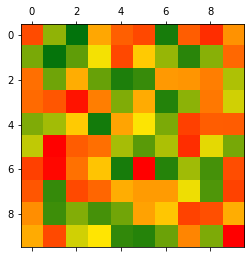

In [ ]:
import matplotlib.colors as clr
import numpy as np
some_matrix = np.random.rand(10,10)
red = "#ff0000"
yellow = '#ffe603'
green = "#02730c"
cmap = clr.LinearSegmentedColormap.from_list('custom', [green,yellow,red], N=256)
plt.matshow(some_matrix, cmap=cmap)
# plt.show()

In [ ]:
# changed_doc_Vis_idxs = np.asarray([np.where(doc_ids == docs_idx_dict['sport'][i])[0][0] for i in range(len(docs_idx_dict['sport'])) ])
# changed_doc_Vis_idxs2 = np.asarray([np.where(doc_ids == docs_idx_dict['tech'][i])[0][0] for i in range(len(docs_idx_dict['tech'])) ])

In [ ]:
# print_Topics(topwords=20)
# print(get_keywords(d_data))
# plot_heatmap1(x_list,changed_doc_Vis_idxs,changed_doc_Vis_idxs2,zphi,query_words,keyword_vis_labels,cmap=cmap,lim=10) # cmap  #magma, seismic, autumn, (Pastel2,Dark2,Paired)

In [ ]:
# changed_doc_Vis_idxs = np.asarray([np.where(doc_ids == i)[0][0] for i in changed_docs_idx])
# plot_heatmap(x_list,changed_doc_Vis_idxs,zphi,query_words,keyword_vis_labels,cmap=cmap,lim=15) # cmap  #magma, seismic, autumn, (Pastel2,Dark2,Paired)

# WTM

In [ ]:
from torch import Tensor
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Parameter
torch.cuda.empty_cache()

epochs = 1000
bs = 256
en1_units_x = 100
en2_units_x = 100
variance_x = 1.0
learning_rate = 0.001
beta1 = 0.99
beta2 = 0.999
dropout = 0.2
num_topic = 15
num_coordinate = 2

#RBF
def gaussian(alpha): return -0.5*alpha
def inverse_quadratic(alpha): return -torch.log(torch.ones_like(alpha) + alpha)

class WTM(nn.Module):
    def __init__(self, num_input, en1_units_x, en2_units_x, num_coordinate, num_topic, drop_rate, variance_x, bs,
                 embedding_words, word_emb_size,activation,distance="gaussian"):

        super(WTM, self).__init__()
        self.num_input, self.num_coordinate, self.num_topic, self.variance_x, self.bs \
            = num_input, num_coordinate, num_topic, variance_x, bs

        self.embedding_words = embedding_words
        self.emb_size = word_emb_size
        self.activation = activation
        self.embedding_words = embedding_words
        self.emb_size = word_emb_size

        # encoder
        self.en1_fc     = nn.Linear(num_input, en1_units_x)
        self.en2_fc     = nn.Linear(en1_units_x, en2_units_x)
        self.mu1_fc     = nn.Linear(2, 100)
        self.mu2_fc     = nn.Linear(100, 100)
        self.mu_fc      = nn.Linear(100, 300)
        self.mu_z = 0

        self.en2_drop   = nn.Dropout(drop_rate)
        self.mean_fc    = nn.Linear(en2_units_x, num_coordinate)
        self.logvar_fc  = nn.Linear(en2_units_x, num_coordinate)

        self.mean_bn    = nn.BatchNorm1d(num_coordinate)
        self.logvar_bn  = nn.BatchNorm1d(num_coordinate)
        self.decoder_x_bn = nn.BatchNorm1d(num_coordinate)
        self.decoder_phi_bn = nn.BatchNorm1d(num_coordinate)
        self.decoder_bn = nn.BatchNorm1d(self.num_topic)
        self.mu_z_bn = nn.BatchNorm1d(self.emb_size)

        # RBF
        self.in_features = self.num_coordinate
        self.out_features = self.num_topic
        self.topics = nn.Parameter(torch.Tensor(self.out_features, self.in_features)) # K x 2
        self.beta_bias = nn.Parameter(torch.Tensor(self.out_features,self.num_input))

        if distance=="gaussian": self.basis_func = gaussian
        if distance=="inverse_quadratic": self.basis_func = inverse_quadratic
        self.init_parameters()

        # prior mean and variance as constant buffers
        prior_mean   = torch.Tensor(1, num_coordinate).fill_(0)
        prior_var    = torch.Tensor(1, num_coordinate).fill_(variance_x)
        self.prior_mean = nn.Parameter(prior_mean, requires_grad=False)
        self.prior_var  = nn.Parameter(prior_var, requires_grad=False)
        self.prior_logvar = nn.Parameter(prior_var.log(), requires_grad=False)

    def init_parameters(self):
        nn.init.normal_(self.topics, 0, 0.1)
        nn.init.normal_(self.beta_bias, 0, 0.01)

    def get_activation(self, activation,layer):
      activation = activation.lower()
      if activation == 'relu':
          layer =  F.relu(layer)
      elif activation == 'softplus':
          layer =  F.softplus(layer)
      elif activation == 'sigmoid':
          layer =  F.sigmoid(layer)
      elif activation == 'leaky_relu':
          layer = F.leaky_relu(layer)
      else:
          layer = F.softplus(layer)
      return layer

    def encode(self, input_):
        N, *_ = input_.size()

        en1 = self.get_activation(self.activation,self.en1_fc(input_))
        en2 = self.get_activation(self.activation,self.en2_fc(en1))

        # en1 = F.softplus(self.en1_fc(input_))
        # en2 = F.softplus(self.en2_fc(en1))

        en2 = self.en2_drop(en2)

        posterior_mean   = self.mean_bn(self.mean_fc(en2))
        posterior_logvar = self.logvar_bn(self.logvar_fc(en2))
        posterior_var    = posterior_logvar.exp()

        return en2, posterior_mean, posterior_logvar, posterior_var

    def take_sample(self, input_, posterior_mean, posterior_var, prior_var):
        eps = input_.data.new().resize_as_(posterior_mean.data).normal_(std=1.0) # noise(epsilon)
        z = posterior_mean + posterior_var.sqrt() * eps     # reparameterization trick
        return z

    def get_beta(self):
        return F.softmax(self.decoder_bn(torch.mm(self.mu_z,self.embedding_words.T).T).T + self.beta_bias,dim=-1)

    def decode(self, z):

      ## Theta - P(z|x,phi) ## NXT
      N, *_ = z.size()
      size = (N, self.out_features, self.in_features) # N,T,2

      ## apply batch normalization across X  (Document coordintes)
      zx = self.decoder_x_bn(z) # Nx2
      x = zx.view(N, 1, self.num_coordinate).expand(size) # Nx1x2

      ## apply batch normalization across phi (Topic coordintes)
      zc = self.decoder_phi_bn(self.topics)
      c = zc.view(1, self.num_topic, self.num_coordinate).expand(size)

      d = (x-c).pow(2).sum(-1)
      distances = self.basis_func(d)
      theta = torch.exp(distances - torch.logsumexp(distances, dim=-1, keepdim=True)) # N x T

      ## Topic Coordinates mapped to topic embeddings
      mu1 = F.softplus((self.mu1_fc(zc)))
      mu2 = F.softplus(self.en2_drop(self.mu2_fc(mu1)))
      self.mu_z = self.mu_fc(mu2)

      ## Beta P(w|z) ## (TxV)
      beta = self.get_beta()
      recon_v = torch.mm(theta,beta)

      return recon_v, zx, theta, zc


    def forward(self, input_, compute_loss=False):
        en2, posterior_mean, posterior_logvar, posterior_var = self.encode(input_)
        z = self.take_sample(input_, posterior_mean, posterior_var, self.variance_x)
        recon_v, zx, theta,zc= self.decode(z)

        if compute_loss:
            return recon_v, zx, self.loss(input_, recon_v, theta, posterior_mean, posterior_logvar, posterior_var, zx)
        else: return z, recon_v, zx, zc, theta

    def KLD(self, posterior_mean,posterior_logvar,posterior_var):
        N = posterior_mean.shape[0]
        prior_mean   = self.prior_mean.expand_as(posterior_mean)
        prior_var    = self.prior_var.expand_as(posterior_mean)
        prior_logvar = self.prior_logvar.expand_as(posterior_mean)

        var_division    = posterior_var  / prior_var
        diff            = posterior_mean - prior_mean
        diff_term       = diff * diff / prior_var
        logvar_division = prior_logvar - posterior_logvar

        KLD = 0.5 * ((var_division + diff_term + logvar_division).sum(-1) - self.num_coordinate)
        return KLD

    def loss(self, input_, recon_v, theta, posterior_mean, posterior_logvar, posterior_var, zx,avg=True):
        N = posterior_mean.shape[0]
        smoothen = 1e-6 # 'error/term-smoothening constant'

        NL = - (input_ * (recon_v+smoothen).log()).sum(-1)
        NL= NL.mean(0)

        KLD = self.KLD(posterior_mean,posterior_logvar,posterior_var).mean(0)

        loss = NL + KLD
        return loss,NL,KLD

## Train

In [ ]:
activation = 'softplus'
embedding_tensor_words = embedding_tensor_sorted_alp.to(device)
emb_size = 300
model = WTM(num_input, en1_units_x, en2_units_x, num_coordinate, num_topic, dropout,variance_x, bs,
  embedding_tensor_words,emb_size,activation, "inverse_quadratic")

kld_arr,recon_arr = [],[]
model.to(device)
all_indices = torch.randperm(train_vec.shape[0]).split(bs)
optimizer = optim.Adam(model.parameters(), learning_rate, betas=(beta1, beta2))
for epoch in range(epochs):

    loss_u_epoch = 0.0 ## NL loss
    loss_KLD = 0.0  ## KL loss
    loss_epoch = 0.0 ## Loss per batch #

    model.train()
    zx_l = []
    label_l = []
    for batch_ndx in all_indices:
    # batch_ndx = all_indices[0]
      input_w = tensor_train_w[batch_ndx].to(device)
      labels = train_label[batch_ndx]
      label_l.extend(labels)
      recon_v, zx, (loss, loss_u, xkl_loss) = model(input_w,compute_loss=True)
      zx_l.extend(zx.data.detach().cpu().numpy())
      optimizer.zero_grad()
      loss.backward()

      optimizer.step()             # backpror.step()
      loss_epoch += loss.item()
      loss_u_epoch += loss_u.item()
      loss_KLD += xkl_loss.item()
      current_model = model
    kld_arr.append(loss_KLD)
    recon_arr.append(loss_u_epoch)

    if epoch % 10 == 0:
        #  print('Epoch -> {}'.format(epoch))
        print('Epoch -> {} , loss -> {}'.format(epoch,loss_epoch))
        print('recon_loss==> {} || KLD==> {}'.format(loss_u_epoch, loss_KLD))
        # plot_fig(np.array(zx_l),label_l,model.decoder_phi_bn(model.centres).data.cpu().numpy(),10.0,'No')

Epoch -> 0 , loss -> 1054.959732055664
recon_loss==> 1040.3919143676758 || KLD==> 14.567823886871338
Epoch -> 10 , loss -> 994.422981262207
recon_loss==> 983.8732223510742 || KLD==> 10.549744009971619
Epoch -> 20 , loss -> 986.6814498901367
recon_loss==> 978.4888000488281 || KLD==> 8.192656815052032
Epoch -> 30 , loss -> 980.1136322021484
recon_loss==> 973.4877471923828 || KLD==> 6.62587696313858
Epoch -> 40 , loss -> 970.0167922973633
recon_loss==> 964.6207733154297 || KLD==> 5.396019220352173
Epoch -> 50 , loss -> 961.8177032470703
recon_loss==> 957.1260223388672 || KLD==> 4.691682159900665
Epoch -> 60 , loss -> 955.4973602294922
recon_loss==> 950.8837509155273 || KLD==> 4.61360365152359
Epoch -> 70 , loss -> 950.8193817138672
recon_loss==> 945.7822799682617 || KLD==> 5.037094712257385
Epoch -> 80 , loss -> 945.9780044555664
recon_loss==> 940.2440032958984 || KLD==> 5.733996331691742
Epoch -> 90 , loss -> 943.6626968383789
recon_loss==> 937.1979904174805 || KLD==> 6.464709758758545
E

## Test

In [ ]:
model.eval()
topwords = 20
x_list = []
labels_list = []
doc_ids = []
zx_phi_list=[]
docs_rscore = []
with torch.no_grad():
    for batch_ndx in all_indices:
        input_w = tensor_train_w[batch_ndx].to(device)
        labels = train_label[batch_ndx]
        labels_list.extend(labels)
        docs_rscore.extend(normalized_all_rscores[batch_ndx])
        z, recon_v, zx,zphi, zx_phi = model(input_w,compute_loss=False)
        zx = zx.data.detach().cpu().numpy()
        zphi = zphi.data.detach().cpu().numpy()
        zx_phi = zx_phi.view(-1, num_topic).data.detach().cpu().numpy()
        zx_phi_list.extend(zx_phi)
        x_list.extend(zx)
        doc_ids.extend(batch_ndx)

    x_list = np.array(x_list)
    labels_list = np.asarray(labels_list)
    docs_rscore = list_of_tensors_to_tensor(docs_rscore)
    beta = model.get_beta().data.cpu().numpy()
    query_words = np.array([[0,0],[0,0],[0,0]])
    keyword_vis_labels = keywords#+['dummy']
    WTM_topics = get_topwords(beta,id_vocab,topwords=topwords)

In [ ]:
key_rscores = []
for k in keywords:
  key_rscores.append(cosine_similarity_desm_docs([k],train_vec,vocab,embeddings))

idx_most_relv_doc = []
for k in range(len(keywords)):
  idx_most_relv_doc.append(torch.sort(key_rscores[k],descending=True).indices[k].item())

0
0


In [ ]:
doc_idx_tensor = list_of_tensors_to_tensor(doc_ids)
batch_most_relv_idx = []
for idx_m in idx_most_relv_doc:
  batch_most_relv_idx.append(torch.where(doc_idx_tensor==idx_m)[0][0].item())

In [ ]:
query_words = [x_list[b] for b in batch_most_relv_idx]
# query_words.append(np.array(([0,0])))
query_words

[array([-5.5611005,  9.121571 ], dtype=float32),
 array([-6.6427574,  4.3023477], dtype=float32)]

- ndcg (topwords  Vs ndcg instead of cosine)
- use rare class A (the class has the min num docs). Select randomly one doc b not in A, inject 30% (vary 10-50%) of a ranomly doc from A to b (append). Repeat |A| times.
- Voc size? (0.7 forllowing ETM)
- WTM straight line?
- Topic coherence
- Topic diversity


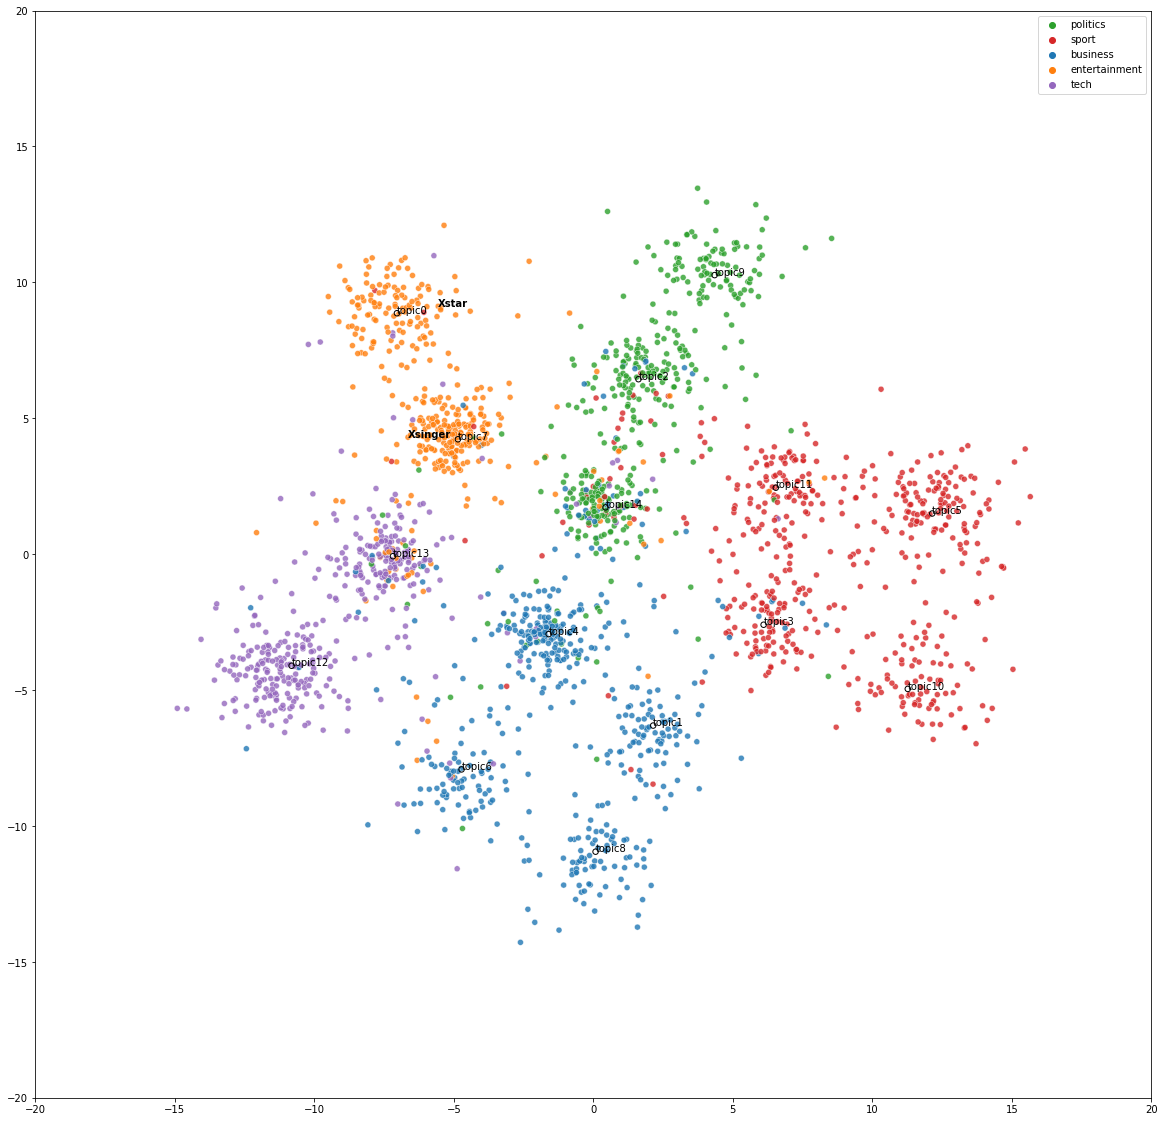

In [ ]:
query_center = [0,0]
plot_fig(x_list, labels_list, zphi,query_center,query_words=query_words,
         keywords=keyword_vis_labels,lim =20,contour='No')

In [ ]:
new_doc_s = key_rscores[0][doc_ids]

In [ ]:
# all_idx = torch.cat((plt_idx[l+1:mid] , plt_idx[:l], plt_idx[-r:]),0) # seq -> middle 0.25 - 0.75 then bottom 0 - 0.25 and finally top 0.75 - 1.0

In [ ]:
# changed_doc_Vis_idxs_wtm = np.asarray([np.where(doc_ids == rand_perm_k_to_change[i])[0][0] for i in range(len(rand_perm_k_to_change)) ])

In [ ]:
# doc_ids = list_of_tensors_to_tensor(doc_ids).numpy()

In [ ]:
changed_doc_Vis_idxs = np.asarray([np.where(doc_idx_tensor == docs_idx_dict['sport'][i])[0][0] for i in range(len(docs_idx_dict['sport'])) ])
changed_doc_Vis_idxs2 = np.asarray([np.where(doc_idx_tensor == docs_idx_dict['politics'][i])[0][0] for i in range(len(docs_idx_dict['politics'])) ])

NameError: ignored

In [ ]:
print_Topics(topwords=20)
print(get_keywords(d_data))

In [ ]:
plot_heatmap1(x_list,changed_doc_Vis_idxs,changed_doc_Vis_idxs2,zphi,query_words,keyword_vis_labels,cmap=cmap,lim=15) # cmap  #magma, seismic, autumn, (Pastel2,Dark2,Paired)

In [ ]:
# print_Topics(topwords=20)
# print(get_keywords(d_data)) #, which_focus,threshold_model
# plot_heatmap(x_list,changed_doc_Vis_idxs_wtm,zphi,query_words,keyword_vis_labels,cmap=cmap,lim=20) # cmap  #magma, seismic, autumn, (Pastel2,Dark2,Paired)

# # plot_heatmap(x_list[all_idx],docs_rscore[all_idx],zphi,query_words,keyword_vis_labels,cmap=cmap,lim=20) # cmap  #magma, seismic, autumn, (Pastel2,Dark2,Paired)
# # plot_heatmap(x_list[plt_idx[-r:]],docs_rscore[plt_idx[-r:]],zphi,query_words,keyword_vis_labels,cmap=cmap,lim=20) # cmap  #magma, seismic, autumn, (Pastel2,Dark2,Paired)

In [ ]:
# plot_heatmap(x_list[changed_doc_Vis_idxs],docs_rscore[changed_doc_Vis_idxs],zphi,query_words,keyword_vis_labels,cmap=cmap,lim=15) # cmap  #magma, seismic, autumn, (Pastel2,Dark2,Paired)

In [ ]:
# plot_heatmap(x_list[sortidx[:100]],docs_rscore[sortidx[:100]],zphi,query_words,keyword_vis_labels,cmap=cmap,lim=20) # cmap  #magma, seismic, autumn, (Pastel2,Dark2,Paired)

In [ ]:
# plot_heatmap(x_list[plt_idx[:100]],docs_rscore[plt_idx[:100]],zphi,query_words,keyword_vis_labels,cmap=cmap,lim=20) # cmap  #magma, seismic, autumn, (Pastel2,Dark2,Paired)

In [ ]:
import numpy as np
from sklearn.metrics import ndcg_score
# we have groud-truth relevance of some answers to a query:
true_relevance = np.asarray([[10, 0, 0, 1, 5]])
# we predict some scores (relevance) for the answers
scores = np.asarray([[.1, .2, .3, 4, 70]])
ndcg_score(true_relevance, scores)

# ____ STOP____

In [ ]:
STOP!!!!

In [ ]:
STOP!!!!

In [ ]:
STOP!!!!

# Sum Cosine Metric

In [ ]:
import plotly.express as px
def plot_relv_topwords(keywords,np_topics_wordsScores):
  for i in range(len(keywords)):
    fig = px.histogram(pd.DataFrame(np_topics_wordsScores[i],columns=['scores']), x="scores")
    print(keywords[i])
    fig.show()
# print("Spike Slab Filter (top # relv words that represents documents):",spikeSlab_filter,"\n\n")

In [ ]:
# PLSV_topics
# WTM_topics
# FoTo_topics


def get_cosine_sum_topics(topwords_cos_sum):
  all_topics = get_topwords(beta,id_vocab,topwords=topwords_cos_sum)
  topics_wordlist = [topics.split(': ')[1].split(" ") for topics in all_topics]
  np_flatten_topics_wordlist = np.array(flatten_list(topics_wordlist))
  topics_wordtensors = get_embedding_tensor(np_flatten_topics_wordlist,embeddings)
  topics_wordsScores,*_ = cosine_keywords(keywords,topics_wordtensors,np_flatten_topics_wordlist,cos_sim)
  np_topics_wordsScores = list_of_tensors_to_tensor(topics_wordsScores)
  return np_topics_wordsScores


# np_topics_wordsScores_WTM = get_cosine_sum_topics(FoTo_topics)
# np_topics_wordsScores_PLSV = get_cosine_sum_topics(PLSV_topics)
np_topics_wordsScores_WTM = get_cosine_sum_topics(topwords_cos_sum=10)
# np_topics_wordsScores_WTM = min_max_norm_1(np_topics_wordsScores_WTM)

# plot_relv_topwords(keywords,np_topics_wordsScores_FoTo)

In [ ]:
def keyw_sum_median_mean(np_topics_wordsScores):
   return keywords,torch.max(np_topics_wordsScores,0).values.sum().item() , torch.mean(np_topics_wordsScores,-1) , torch.median(np_topics_wordsScores,-1).values

In [ ]:
_,sum_max,_,_ = keyw_sum_median_mean(np_topics_wordsScores_WTM)
print(sum_max)

15.985258102416992


In [ ]:
def plot_cosine_sum(x,y,name):
  fig = go.Figure()
  df = pd.DataFrame(list(zip(x,y)),columns = ['topwords','cos_sum'])
  fig = px.line(df, x='topwords', y='cos_sum',  text='cos_sum')
  fig.update_traces(textposition="bottom right")
  # fig.show()
  # figure.add_trace(go.Scatter(x=x, y=y,mode='lines',name=name, text=str(y)))
  fig.show(renderer='colab')

In [ ]:
a = [i for i in range(10,100,10)]
cos_sum_max = []
for i in a:
  np_topics_wordsScores_WTM = get_cosine_sum_topics(topwords_cos_sum=i)
  _,sum_max,_,_ = keyw_sum_median_mean(np_topics_wordsScores_WTM)
  cos_sum_max.append(sum_max)

In [ ]:
cos_sum_max

[15.985258102416992,
 31.262832641601562,
 47.74919128417969,
 62.70668411254883,
 76.5947036743164,
 91.42622375488281,
 106.56011199951172,
 121.78340148925781,
 134.78677368164062]

In [ ]:
plot_cosine_sum(a,cos_sum_max,"cos_sum_V_topwords")

In [ ]:
print_keyw_sum_median_mean(np_topics_wordsScores_FoTo)

NameError: ignored

In [ ]:
print_keyw_sum_median_mean(np_topics_wordsScores_PLSV)

In [ ]:
plot_relv_topwords(keywords,np_topics_wordsScores_WTM)

#NDCG Score

In [ ]:
from sklearn.metrics import ndcg_score
## example
true_relevance = np.asarray([[10, 0, 0, 1, 5]])
scores = np.asarray([[.1, .2, .3, 4, 70]])
ndcg_score(true_relevance, scores)

0.6956940443813076

In [ ]:
def get_ndcg_topics(topwords_cos_sum):
  all_topics = get_topwords(beta,id_vocab,topwords=topwords_cos_sum)
  topics_wordlist = [topics.split(': ')[1].split(" ") for topics in all_topics]
  sorted_cosine_keywords = torch.sort(val,descending=True)
  ids_of_words = []
  for topics in topics_wordlist:
    id_words_topic = []
    for words in topics:
      sorted_cosine_keywords.values
      id_words_topic.append(vocab[words])
    ids_of_words.append(id_words_topic)

  order_topwords = np.arange(topwords_cos_sum,0,-1)
  ndcg_topic = {}
  max_cos_for_topwords = torch.max(sorted_cosine_keywords.values,0).values
  # print(max_cos_for_topwords)
  for ids in ids_of_words:
    true_relevance = np.asarray([order_topwords])
    scores = np.asarray([max_cos_for_topwords[ids].numpy()])
    ndcg_sc = ndcg_score(true_relevance, scores)
    ndcg_topic.setdefault(keywords[0],[]).append(ndcg_sc)

  # cos_for_topwords = sorted_cosine_keywords.indices
  # order_topwords = np.arange(topwords_cos_sum,0,-1)
  # for i in range(len(cos_for_topwords)):
  #   # print('\n\n\n\n')
  #   for ids in ids_of_words:
  #     true_relevance = np.asarray([order_topwords])
  #     # print(keywords[i],cos_for_topwords[i][ids].numpy())
  #     scores = np.asarray([cos_for_topwords[i][ids].numpy()])
  #     ndcg_sc = ndcg_score(true_relevance, scores)
  #     ndcg_topic.setdefault(keywords[i],[]).append(ndcg_sc)
  gc.collect()
  return ndcg_topic


In [ ]:
a = [i for i in range(10,100,10)]
ndcg_sum_max = []
def toT(a): return torch.tensor(a)
for i in a:
  ndcg_topic = get_ndcg_topics(topwords_cos_sum=i)
  ndcg_topic_scores = toT(np.asarray(list(ndcg_topic.values())))
  _,sum_max,_,_ = keyw_sum_median_mean(ndcg_topic_scores)
  ndcg_sum_max.append(sum_max)

In [ ]:
ndcg_sum_max

[12.431380477012464,
 12.419263840845602,
 12.257638684279117,
 12.065759851384305,
 12.127536966454773,
 12.175671514268892,
 12.213057227366612,
 12.376113334327043,
 12.356216786674208]

In [ ]:
wtm_ndcg = []

In [ ]:
plot_relative_diff(a,ndcg_sum_max,wtm_ndcg,"WTM","ndcg_V_topwords","ndcg_score","topwords")

# Furthur Evaluation (TTM etc..)

In [ ]:
np_topics_wordsScores_FoTo

In [ ]:
## ToDo

# vis of bbc, searchsnippet: Foto, TTM, WTM: 10, 20, 30 topics, old beta, heatmap
# sum cosine scores top words (10, 20)

In [ ]:
# New Beta cos (for long text) -
# softmax((\tau*\keyEmbT)*\cos)
# ------------------------------
# 0: democracy korean representative star actress action war republic actor amazon stanford college party asian photo school info president critic life
# 1: news wikipedia business computer system online game resource encyclopedia health web wiki sport article theory journal service book program link
# 2: physic computer service device sale digital theme drama software music performance radio field journal internet database program driver development company
# 3: gov team news product topic global issue cover solution management source article consumer overview history application division multi learn system
# 4: drama art classical dance character literature beatles ballet architecture television fashion cup artist photography literary philosopher doctor museum film movie
# 5: solving square maintenance implication enabling lose monitoring roadmap amp disaster handling monitor vendor problem control environmental solution recovery function measure
# 6: movie culture film school democracy college star actor war blog republic car chinese forum tom character action doctor actress football
# 7: korean eng representative gov korea sun star democracy actress spotlight dennis powered action doc ngo head israel bush men cross
# 8: science music art yahoo political library market search student course theoretical site video job american fashion graduate philosophy digital museum
# 9: democracy korean representative star actress action war republic actor amazon stanford college party asian photo school info president critic life
# ------------------------------
# ['korean', 'drama']

# --------------------------------------- VS -------------------------------------------
# Old Beta cos (For short text)
# softmax ( (\omegaT*\tau).cos)
# ------------------------------
# 0: game sport news football wikipedia soccer team league player tennis match ticket wiki espn article club website racing encyclopedia olympic
# 1: computer software network memory web drug intel system electrical linux server device company virtual download motor core processor source document
# 2: wikipedia journal theory computer program system web science university article wiki paper theoretical programming encyclopedia physic center data link engineering
# 3: amazon book history wikipedia car house online film encyclopedia award video model search american people photo event production community wiki
# 4: business health gov market service trade cancer economic product management news disease national bank global exchange federal stock resource public
# 5: party democracy political war system republic government democratic presidential election president income parliamentary politics automatic stress people europe representative tax
# 6: movie culture imdb star news american oscar film actor disney tom director george ancient robert character cartoon guide biography leonardo
# 7: science school library news student yahoo course directory job education online resource graduate study search site philosophy physical degree master
# 8: gov engine calorie military healthy hiv diet theorem food diagnosis aid fitness force hospital earth medical weapon north legislation weight
# 9: music art fashion digital band artist lyric review wheel rock album classical romantic video piano painting camera pop designer television
# ------------------------------
# ['korean', 'drama']

In [ ]:
## How much are the topic topwords relevant to keywords
## (Calc using cosine sim score)
# with_cos_score_more_than = 0.45

all_topics = get_topwords(beta,id_vocab,topwords=30)
topics_wordlist = [topics.split(': ')[1].split(" ") for topics in all_topics]
# topic_key_idx = [flatten_topics_wordlist.index(k) for k in keywords]
np_flatten_topics_wordlist = np.array(flatten_list(topics_wordlist))
topics_wordtensors = get_embedding_tensor(np_flatten_topics_wordlist,embeddings)

topics_wordsScores,*_ = cosine_keywords(keywords,topics_wordtensors,np_flatten_topics_wordlist,cosine_sqrt)
# np_topics_wordsScores = torch_min_max_sim(list_of_tensors_to_tensor(topics_wordsScores),topic_key_idx,3)
np_topics_wordsScores = list_of_tensors_to_tensor(topics_wordsScores)
# relv_topic_words = flatten_topics_wordlist[np.where(topics_wordsScores>with_cos_score_more_than)[0]]
# relv_topic_words , len(relv_topic_words)
len(np_flatten_topics_wordlist)

In [ ]:
keywords,torch.max(np_topics_wordsScores,0).values.sum().item() , torch.mean(np_topics_wordsScores,-1) , torch.median(np_topics_wordsScores,-1).values

In [ ]:
plot_relv_topwords(keywords,np_topics_wordsScores)

In [ ]:
# save_obj(beta,'beta_'+d_data)
# save_obj(id_vocab,'id_vocab_'+d_data)
# save_obj(keywords,'keywords_'+d_data)
# !zip -r bbc_results_t15_3k_FoTo.zip *.pkl

In [ ]:
!wget -N -c https://www.dropbox.com/s/s0xi2fnk5kz72wx/ttm_more_results.zip
!unzip -o ttm_more_results.zip

In [ ]:
from os import listdir
from os.path import isfile, join
import pandas as pd
# % cd /content/short
mypath = "/content/short"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
csv_files = []
for o in onlyfiles:
  for k in keywords:
    if k+"-PT-5-1-Iter-250" in o and "target-keyword" in o:
      csv_files.append(o)

## get all words
all_words = []
for c in csv_files:
  df = pd.read_csv(c)
  words = df.values.reshape(-1)
  words_cleaned = [a for a in words if str(a).isalpha() == True and str(a) != 'nan']
  all_words.extend(words_cleaned[:150])
all_words = np.asarray(all_words)

topics_wordtensors = get_embedding_tensor(all_words,embeddings)
topics_wordsScores,*_ = cosine_keywords(keywords,topics_wordtensors,np_flatten_topics_wordlist,cosine_sqrt)
np_topics_wordsScores = list_of_tensors_to_tensor(topics_wordsScores)
# len(all_words)

In [ ]:
keywords,torch.max(np_topics_wordsScores,0).values.sum().item() , torch.mean(np_topics_wordsScores,-1) , torch.median(np_topics_wordsScores,-1).values

In [ ]:
plot_relv_topwords(keywords,np_topics_wordsScores)

In [ ]:
## how to select topwords for TTM if topics have empty topwords?
## the cosine score is as per the embeddings we generated is that fair?

# Save/Download Results

In [ ]:
STOP!!

In [ ]:
doc_ids_model = [i.item() for i in doc_ids]

In [ ]:
save_obj(get_topwords(beta, id_vocab),"top100_docmodel_"+d_data)

In [ ]:
save_obj(x_list,"x_list")
save_obj(indices,"doc_id_desm")
save_obj(doc_ids_model,"doc_ids_model")
save_obj(labels_list,"labels_list")
save_obj(all_rscores,"all_rscores")
save_obj(keywords,'keywords_'+d_data)

In [ ]:
from google.colab import files
files.download("doc_ids_model.pkl")
files.download("doc_id_desm.pkl")
files.download("x_list.pkl")
files.download("labels_list.pkl")
files.download("all_rscores.pkl")
files.download("keywords_"+d_data+".pkl")
files.download("top100_docmodel_"+d_data+".pkl")

In [ ]:
rm -r *.pkl*